<a href="https://colab.research.google.com/github/Saimoncastro/Dataset-proyecto-coder/blob/main/ProyectoParteIII%2BCastroAlvarez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Datos cargados desde CSV. Shape: (429435, 67)
  iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-01-05          0.0        0.0   
1      AFG      Asia  Afghanistan  2020-01-06          0.0        0.0   
2      AFG      Asia  Afghanistan  2020-01-07          0.0        0.0   
3      AFG      Asia  Afghanistan  2020-01-08          0.0        0.0   
4      AFG      Asia  Afghanistan  2020-01-09          0.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           0.0         0.0                  NaN  ...   
1                 NaN           0.0         0.0                  NaN  ...   
2                 NaN           0.0         0.0                  NaN  ...   
3                 NaN           0.0         0.0                  NaN  ...   
4                 NaN           0.0         0.0                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_

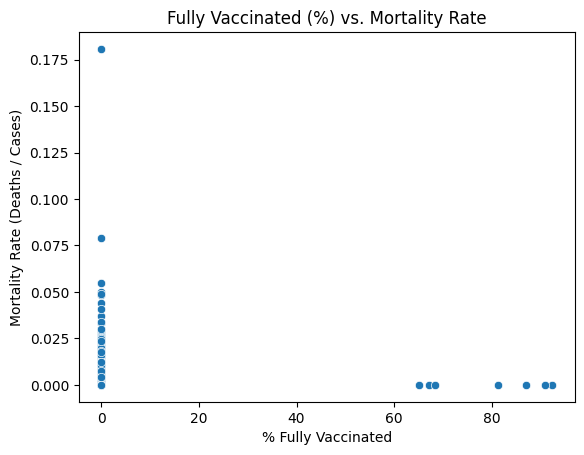

Correlación entre % fully vaccinated y mortality rate: -0.1305


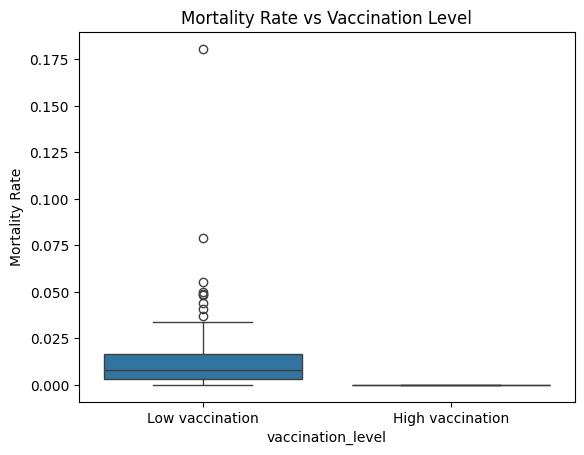

T-test → t: -11.6583, p: 0.0000


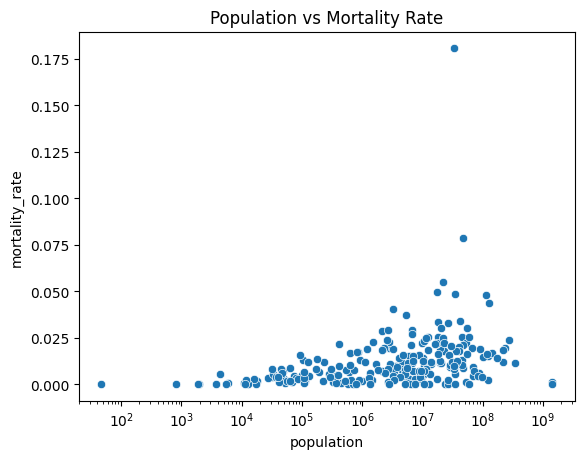

Correlación población vs mortalidad: -0.0029209687821352007


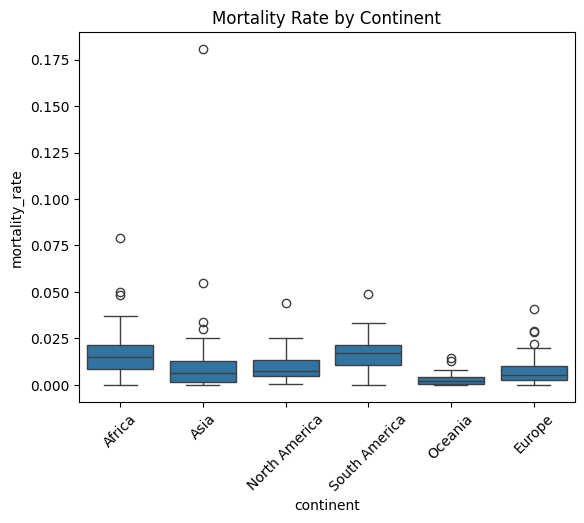

ANOVA → F: 3.8801, p: 0.0021
mortality_class
1    154
0     83
Name: count, dtype: int64
Antes de SMOTE: [ 66 123]
Después de SMOTE: [123 123]
✅ Accuracy: 0.7708333333333334
✅ Balanced Accuracy: 0.7163187855787476
✅ ROC AUC: 0.7239089184060721

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.78      0.90      0.84        31

    accuracy                           0.77        48
   macro avg       0.76      0.72      0.73        48
weighted avg       0.77      0.77      0.76        48



In [12]:
#importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split

# --- LEER CSV CLONADO DE GITHUB ---
df_raw = pd.read_csv("covid-19-data/public/data/owid-covid-data.csv")

print("✅ Datos cargados desde CSV. Shape:", df_raw.shape)
print(df_raw.head())

# --- PROCESAR: obtener último registro por país ---
# excluir agregados globales OWID_*
df_raw = df_raw[~df_raw["iso_code"].str.startswith("OWID")]

# ordenar por fecha y quedarnos con la última por país
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_last = df_raw.sort_values("date").groupby("iso_code").tail(1)

# seleccionar variables de interés
df = df_last[[
    "iso_code", "location", "continent", "population",
    "total_cases", "total_deaths", "people_vaccinated", "people_fully_vaccinated", "date"
]].copy()

print("✅ DataFrame limpio:", df.shape)
print(df.head())

# --- LIMPIEZA ---
cols_to_clean = ["total_cases","total_deaths","people_vaccinated","people_fully_vaccinated","population"]
df[cols_to_clean] = df[cols_to_clean].fillna(0)
df["continent"] = df["continent"].fillna("Unknown")

# --- MÉTRICAS ---
df["mortality_rate"] = df.apply(
    lambda x: (x["total_deaths"] / x["total_cases"]) if x["total_cases"] > 0 else 0, axis=1
)
df["pct_fully_vaccinated"] = df.apply(
    lambda x: (x["people_fully_vaccinated"] / x["population"] * 100) if x["population"] > 0 else 0, axis=1
)

print(df[["location", "pct_fully_vaccinated", "mortality_rate"]].head())

# Variable target binaria (hipótesis de mortalidad alta > 2%)
for thr in [0.02, 0.01, 0.005]:
    df["mortality_class"] = df["mortality_rate"].apply(lambda x: 1 if x > thr else 0)
    print(f"Umbral {thr} →", df["mortality_class"].value_counts().to_dict())


# --- VISUALIZACIONES ---
sns.scatterplot(data=df, x="pct_fully_vaccinated", y="mortality_rate")
plt.title("Fully Vaccinated (%) vs. Mortality Rate")
plt.xlabel("% Fully Vaccinated")
plt.ylabel("Mortality Rate (Deaths / Cases)")
plt.show()

corr_value = df["pct_fully_vaccinated"].corr(df["mortality_rate"])
print(f"Correlación entre % fully vaccinated y mortality rate: {corr_value:.4f}")

# Crear grupos por vacunación
df["vaccination_level"] = df["pct_fully_vaccinated"].apply(
    lambda x: "High vaccination" if x >= 70 else "Low vaccination"
)

sns.boxplot(data=df, x="vaccination_level", y="mortality_rate")
plt.title("Mortality Rate vs Vaccination Level")
plt.ylabel("Mortality Rate")
plt.show()

# --- TEST ESTADÍSTICO ---
group_high = df[df["vaccination_level"]=="High vaccination"]["mortality_rate"]
group_low = df[df["vaccination_level"]=="Low vaccination"]["mortality_rate"]

t_stat, p_val = stats.ttest_ind(group_high, group_low, equal_var=False)
print(f"T-test → t: {t_stat:.4f}, p: {p_val:.4f}")

# --- Hipótesis 2: Población vs Mortalidad ---
sns.scatterplot(data=df, x="population", y="mortality_rate")
plt.xscale("log")
plt.title("Population vs Mortality Rate")
plt.show()
print("Correlación población vs mortalidad:", df["population"].corr(df["mortality_rate"]))

# --- Hipótesis 3: Continentes ---
sns.boxplot(data=df, x="continent", y="mortality_rate")
plt.title("Mortality Rate by Continent")
plt.xticks(rotation=45)
plt.show()

groups = [g["mortality_rate"].values for _, g in df.groupby("continent")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA → F: {f_stat:.4f}, p: {p_val:.4f}")

print(df["mortality_class"].value_counts())

# --- Machine Learning ---
# ==============================
# 1. Features y target
# ==============================
features = ["total_deaths", "people_fully_vaccinated", "pct_fully_vaccinated"]
X = df[features].fillna(0)
y = df["mortality_class"]

# ==============================
# 2. Train-test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 3. Aplicar SMOTE SOLO en train
# ==============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Antes de SMOTE:", np.bincount(y_train))
print("Después de SMOTE:", np.bincount(y_train_res))

# ==============================
# 4. Entrenar Random Forest
# ==============================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train_res, y_train_res)

# ==============================
# 5. Predicciones y métricas
# ==============================
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("✅ ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

1. Análisis descriptivo y correlaciones

Correlación % vacunación completa vs. mortalidad:
Fue negativa (-0.13) → sugiere que a mayor cobertura de vacunación completa, menor tasa de mortalidad.
Aunque la correlación es baja, sí es estadísticamente significativa (p ≈ 0.000).

Correlación población vs mortalidad:
Prácticamente nula (≈ -0.0029). La población de un país no explica la mortalidad directamente.

ANOVA por continentes:
Hay diferencias estadísticamente significativas en la mortalidad entre continentes (F ≈ 3.88, p ≈ 0.0021).
→ Esto indica que el contexto geográfico y regional influye (sistemas de salud, políticas sanitarias, etc.).

2. Clasificación (modelo predictivo)

Sin SMOTE: el modelo ignoraba casi por completo la clase minoritaria (países con alta mortalidad).

Con SMOTE + Random Forest:

Accuracy global ≈ 77%

Balanced accuracy ≈ 71% (mejor que el azar, que sería 50%)

ROC AUC ≈ 0.72 (modelo razonablemente bueno para diferenciar países de alta vs baja mortalidad)

La clase minoritaria (alta mortalidad) obtuvo recall de 0.90 → el modelo detecta muy bien los países con riesgo alto, aunque a costa de equivocarse más en algunos de baja mortalidad.

Por tanto se tuvo que incluir esta modalidad para realizar un mejor modelo.

Conclusiones Generales

La vacunación sí tiene relación con la mortalidad: aunque la correlación sea débil, el test estadístico indica que la asociación es real y significativa.

El continente importa: factores estructurales (recursos médicos, políticas de respuesta, edad poblacional) influyen en los niveles de mortalidad.

Modelos sin balanceo no sirven en este caso: ignoran la clase de mayor interés (alta mortalidad). SMOTE fue crucial.

El modelo predictivo es prometedor: alcanza buen recall en los casos críticos (alta mortalidad), lo cual es útil desde un punto de vista de salud pública (mejor detectar falsos positivos que dejar pasar un país de riesgo).

Futuras mejoras: ajustar hiperparámetros, probar modelos más avanzados (XGBoost, LightGBM), y agregar más features (por ejemplo: edad media, camas hospitalarias, índice de desarrollo humano).